In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
columns = channels
frequencies = ['8.18', '9', '10', '11.25', '12.85', '15']


data, header = pyxdf.load_xdf('../data/ERPSpellerDataV1/ERPSpellerDataA30Sec8-18hz/dejittered-unity-frequencies.xdf')


In [3]:

def plot_single(df,df_ts, column):
    axis = plt.subplot()
    axis.plot(df_ts['time'], df[column])
    axis.set_title(column)
    plt.show()

def plot_eeg(df, df_ts):
    df.columns = columns
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.plot(df_ts['time'], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()





In [4]:
def load_frequencies(path = '../data/ERPSpellerDataV1/ERPSpellerDataA30Sec8-18hz'):
    data, header = pyxdf.load_xdf(path+'/dejittered-unity-frequencies.xdf')
    df_stream = None
    df_stream_ts = None
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = frequencies
    return df_stream, df_stream_ts

def load_eeg(path = '../data/ERPSpellerDataV1/ERPSpellerDataA30Sec8-18hz'):
    data, header = pyxdf.load_xdf(path+'/dejittered-eeg.xdf')
    df_stream = None
    df_stream_ts = None
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = channels
    return df_stream, df_stream_ts

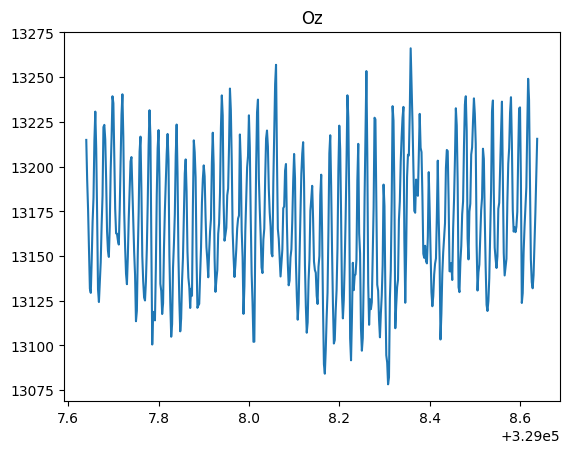

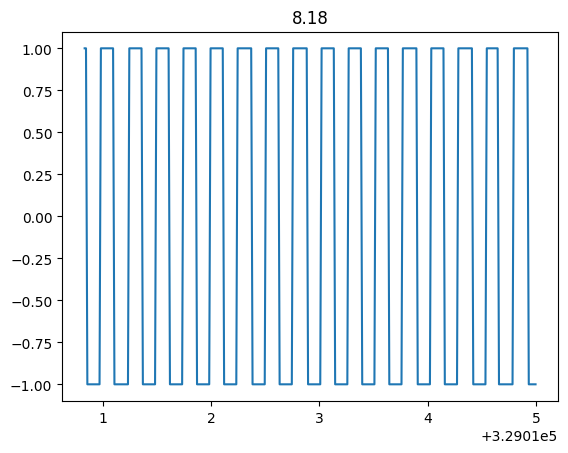

In [5]:
flip = False
df_eeg, df_ts_eeg = load_eeg()
df_freq, df_ts_freq = load_frequencies()
chosen_channel = 'Oz'

start = 500
end = 1000
fre = 80/120
plot_single(df_eeg[start:end], df_ts_eeg[start:end], chosen_channel)
plot_single(df_freq[round(start*fre):round(end*fre)], df_ts_freq[round(start*fre):round(end*fre)], '8.18')

